# NBA Data Analysis

The data used in this notebook was downloaded from [Kaggle](https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv).  The original source of the data is [Basketball-reference](http://www.basketball-reference.com/).


## General Intro EDA

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

data_url = "https://docs.google.com/spreadsheets/d/1m0jaYL1KGjxW1cKJUQxVTcPOnm7v7NZEBKRZADCmc68/export?format=csv"
nba = pd.read_csv(data_url)
nba.head()

/usr/local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,0.368,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,0.435,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,0.394,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,0.312,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,0.308,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


<IPython.core.display.Javascript object>

Preprocessing from before:

In [3]:
nba = nba.drop(columns=["blank2", "blanl"])
nba = nba.dropna(subset=["Year", "Player", "Pos", "Tm"])

<IPython.core.display.Javascript object>

## Feature Engineering

We have a lot of useful data here, but most predictive models that we'll be looking at only like numeric data.  To still use our information we have to do a little bit of reformatting.

### One Hot Encoding / Dummy Encoding

For example, for team, we might "one-hot encode" (aka create dummy variables).  This is a way of creating a series of variables indicating True/False.

Create a dataframe that is a subset of the `nba` dataframe.  Only include in this subset:

* Columns: `PTS`, `Player`, & `Tm`
* Rows: a random selection of 15 rows (use 42 as the `random_state`)

In [4]:
# subset columns
nba_sub = nba[["PTS", "Player", "Tm"]]

# subset rows
nba_sub = nba_sub.sample(n=15, random_state=42)

nba_sub

,PTS,Player,Tm
19756,191.0,Morris Peterson,NOH
20547,79.0,Earl Barron,TOT
9517,158.0,Eric White,LAC
12379,228.0,Bimbo Coles,GSW
6383,444.0,Alvin Scott,PHO
14879,774.0,Joe Smith,MIN
5892,607.0,Ollie Johnson,CHI
14520,131.0,Ryan Bowen,DEN
6879,212.0,Jeff Cook,CLE
2534,100.0,Jim Fox,CIN


<IPython.core.display.Javascript object>

Use `pd.get_dummies()` on the subset.

* What happened?
* What might we change about this and why?
* What does the `drop_first` argument of `pd.get_dummies()` do and why?

In [5]:
a = pd.get_dummies(nba_sub)
a.shape

(15, 28)

<IPython.core.display.Javascript object>

In [6]:
b = pd.get_dummies(nba_sub, columns=["Tm"])
b.shape

(15, 14)

<IPython.core.display.Javascript object>

In [7]:
c = pd.get_dummies(nba_sub, columns=["Tm"], drop_first=True)
c.shape

(15, 13)

<IPython.core.display.Javascript object>

There are some issues that come up with using `pd.get_dummies` in a machine learning workflow.  For today, we'll stick with it due to its ease of use compared to more powerful options.

Using [`sklearn.preprocessing.OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) overcomes the issues that `pd.get_dummies` can run into, but it has a little more complex usage.

### Binary Encoding

Create a binary column named `is_old` that shows whether or not the `Year` variable is before 1980.

In [8]:
nba["is_old"] = nba["Year"] < 1980
nba["is_old"] = nba["is_old"].astype(int)
nba["is_old"]

0        1
1        1
2        1
3        1
4        1
        ..
24686    0
24687    0
24688    0
24689    0
24690    0
Name: is_old, Length: 24624, dtype: int64

<IPython.core.display.Javascript object>

Create a binary column named `is_california` that shows whether or not a team is located in california.

In [9]:
ca_teams = ["LAL", "LAC", "GSW", "SAC"]

nba_sub["is_california"] = nba_sub["Tm"].isin(ca_teams)
nba_sub

,PTS,Player,Tm,is_california
19756,191.0,Morris Peterson,NOH,False
20547,79.0,Earl Barron,TOT,False
9517,158.0,Eric White,LAC,True
12379,228.0,Bimbo Coles,GSW,True
6383,444.0,Alvin Scott,PHO,False
14879,774.0,Joe Smith,MIN,False
5892,607.0,Ollie Johnson,CHI,False
14520,131.0,Ryan Bowen,DEN,False
6879,212.0,Jeff Cook,CLE,False
2534,100.0,Jim Fox,CIN,False


<IPython.core.display.Javascript object>

### Ordinal Encoding

Let's make up some data to be ordinal encoded.

* Using the `grades` list create a sample of 20 random letters
* Create a 1 column DataFrame from this sample

In [10]:
np.random.seed(42)

grades = ["A", "B", "C", "D", "F"]
rand_grades = np.random.choice(grades, size=20)

grade_df = pd.DataFrame({"grade": rand_grades})
grade_df.head()

,grade
0,D
1,F
2,C
3,F
4,F


<IPython.core.display.Javascript object>

Create a variable that is an ordinal encoding of grade.  Have `A` be 1 and `F` be 5.

In [11]:
grade_map = {"A": 1, "B": 2, "C": 3, "D": 4, "F": 5}

grade_df["grade_num"] = grade_df["grade"].replace(grade_map)
grade_df.head()

,grade,grade_num
0,D,4
1,F,5
2,C,3
3,F,5
4,F,5


<IPython.core.display.Javascript object>

### Scaling

Some methods we'll see are sensitive to our variables being on different scales.  For example, if you have variables for a person's height and their annual income, the height feature will have a much much smaller value than the income feature.  In some methods, this will lead to the income variable being a louder signal than the height variable.  Larger magnitude variables can end up drowning out smaller magnitude ones, and this can be an issue if we think height will be an important predictor.

To address this issue, we can scale the variables to have equal footing.  This won't change the shape of their distribution.  Not changing shape means that the patterns within and between the variable aren't lost by scaling, the patterns are preserved, the values have just been standardized.

* Create a subset of the nba dataset that has the columns `PTS` and `Age`.
* Drop all NAs
* Use the pandas boxplot method on this resulting data.
* Plot these variables on a scatter plot.

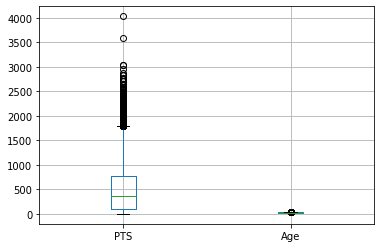

<IPython.core.display.Javascript object>

In [12]:
nba_sub = nba[["PTS", "Age"]].dropna()
nba_sub.boxplot()
plt.show()

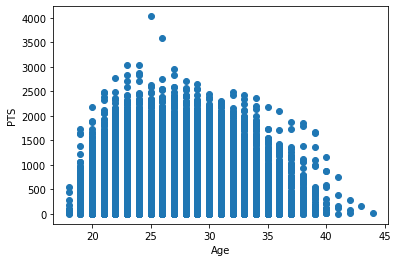

<IPython.core.display.Javascript object>

In [13]:
plt.scatter(nba_sub["Age"], nba_sub["PTS"])
plt.xlabel("Age")
plt.ylabel("PTS")
plt.show()

We're going to split into groups to evaluate 2 different scalers.  The below code will decide the groups.

In [14]:
np.random.seed(55)

# fmt: off
data_scientists = ['Anthony', 'Dillan', 'Gaukhar', 'Harinder', 'James',
                   'Josh', 'Leon', 'Mason', 'Rachel', 'Steve']
# fmt: on

# Randomize order
np.random.shuffle(data_scientists)

n = len(data_scientists) // 2
print(f"Use StandardScaler: {data_scientists[:n]}")
print(f"Use MinMaxScaler: {data_scientists[n:]}")

Use StandardScaler: ['James', 'Anthony', 'Gaukhar', 'Dillan', 'Harinder']
Use MinMaxScaler: ['Leon', 'Steve', 'Josh', 'Rachel', 'Mason']


<IPython.core.display.Javascript object>

In [15]:
# Pick your poison (comment out the one that your group isn't doing)
scaler = StandardScaler()
# scaler = MinMaxScaler()

<IPython.core.display.Javascript object>

* Use a scaler to scale the `PTS` and `Age` data.
* The output of the scaler is a numpy array, convert this back to a dataframe
* Recreate the same box plots from before.
  * What's the same?
  * What's different?
  * What's the minimum value of the numeric axis? the max value?

In [16]:
# .fit() methods 'learn' something from your data
# They don't apply any of these learnings
# In the case of a scaler we have to call .transform
# Alternatively, we could use .fit_transform() to do
# both of these things in one step
scaler.fit(nba_sub)

scaled = scaler.transform(nba_sub)

scaled_df = pd.DataFrame(scaled, columns=["PTS", "Age"])
scaled_df.head()

,PTS,Age
0,-0.106010,1.128528
1,-0.469145,0.607941
2,-0.146584,-0.433234
3,-0.907340,-0.693528
4,-0.915455,-0.693528


<IPython.core.display.Javascript object>

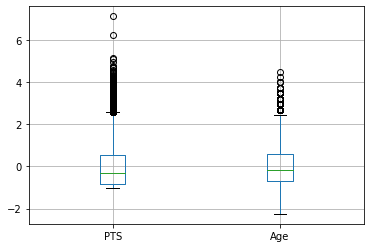

<IPython.core.display.Javascript object>

In [17]:
# the data is now on the same 'scale'
scaled_df.boxplot()
plt.show()

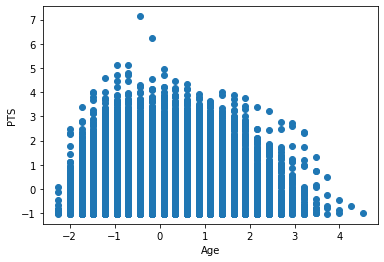

<IPython.core.display.Javascript object>

In [18]:
# The relationship between the variables is unchanged
plt.scatter(scaled_df["Age"], scaled_df["PTS"])
plt.xlabel("Age")
plt.ylabel("PTS")
plt.show()

* Bonus: what attributes does your scaler have? What is the significance of these?

In [19]:
# commented out since it's a large print out
# dir(scaler)

<IPython.core.display.Javascript object>

* Bonus Bonus: can you recreate this same scaling from scratch?

I'll just do a single column for ease.

In [20]:
# MinMaxScaler
x = nba_sub["PTS"]

# essentially what MinMaxScaler.fit() does
min_ = x.min()
max_ = x.max()

# essentially what MinMaxScaler.transform() does

# We want the min to be zero. So we subtract the min.
# (ie if min is `5` then we'll do `5 - 5` which makes the new min 0).

# We want the max to be 1. So we divide by the max.
# (ie if max is `10` then we'll do `10 / 10` which makes the new max 1)

# Note we have to subtract the min from the max before doing the division
scaled = (x - min_) / (max_ - min_)

stats.describe(scaled)

DescribeResult(nobs=24616, minmax=(0.0, 1.0), mean=0.12664572005704824, variance=0.014969052026546444, skewness=1.2198639292036388, kurtosis=1.2372416284618017)

<IPython.core.display.Javascript object>

In [21]:
# StandardScaler
x = nba_sub["PTS"]

# essentially what StandardScaler.fit() does
mean_ = x.mean()
std_ = x.std()

# essentially what StandardScaler.transform() does

# We want the mean to be zero. So we subtract the mean.
# (ie if mean is `5` then we'll do `5 - 5` which makes the new mean 0).

# We want the numbers to indicate how many stds away from the mean
# they are. So we divide by the std.

scaled = (x - mean_) / std_

stats.describe(scaled)

DescribeResult(nobs=24616, minmax=(-1.0351263609530668, 7.13827547597272), mean=4.365842898265972e-17, variance=1.0, skewness=1.21986392920364, kurtosis=1.2372416284618044)

<IPython.core.display.Javascript object>